## CIS 580, Machine Perception, Spring 2023
### Homework 5
#### Due: Thursday April 27th 2023, 11:59pm ET

### Part 1: Fitting a 2D Image

Instructions: Create a folder in your Google Drive and place inside this .ipynb file. Open the jupyter notebook with Google Colab. 

In [1]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import time
import gdown

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#print(device)

We first download the image from the web. We normalize the image so the pixels are in between the range of [0,1].

In [3]:
url = "https://drive.google.com/file/d/1-Cugk9WiFX2CPjWG5taX3868Gdd0PEVT/view?usp=share_link"
gdown.download(url=url, output='starry_night.jpg', quiet=False, fuzzy=True)

# Load painting image
painting = imageio.imread("starry_night.jpg")
painting = torch.from_numpy(np.array(painting, dtype=np.float32)/255.)
height_painting, width_painting = painting.shape[:2]

Downloading...
From: https://drive.google.com/uc?id=1-Cugk9WiFX2CPjWG5taX3868Gdd0PEVT
To: /content/starry_night.jpg
100%|██████████| 5.65k/5.65k [00:00<00:00, 6.84MB/s]


1.1 Complete the function positional_encoding()

In [4]:
def positional_encoding(x, num_frequencies=6, incl_input=True):
    
    """Apply positional encoding to the input.

    Args:
    x (torch.Tensor): Input tensor to be positionally encoded. 
      The dimension of x is [N, D], where N is the number of input coordinates,
      and D is the dimension of the input coordinate.
    num_frequencies (optional, int): The number of frequencies used in
     the positional encoding default: 6).
    incl_input (optional, bool): If True, concatenate the input with the 
        computed positional encoding (default: True).

    Returns:
    (torch.Tensor): Positional encoding of the input tensor. 
    """
    
    results = []
    if incl_input:
        results.append(x)
    #############################  TODO 1(a) BEGIN  ############################
    # encode input tensor and append the encoded tensor to the list of results.
    X = x.clone().detach() 
    for i in range(0, num_frequencies):
      gamma = 2**(i)*np.pi
      results.append(torch.sin(gamma*X))
      results.append(torch.cos(gamma*X))

    #############################  TODO 1(a) END  ##############################
    return torch.cat(results, dim=-1)

1.2 Complete the class model_2d() that will be used to fit the 2D image.


In [5]:
class model_2d(nn.Module):
    
    """
    Define a 2D model comprising of three fully connected layers,
    two relu activations and one sigmoid activation.
    """
    
    def __init__(self, filter_size=128, num_frequencies=6):
        super().__init__()
        #############################  TODO 1(b) BEGIN  ############################
        self.fun1 = nn.Linear(26,filter_size)
        self.relu = nn.ReLU()
        self.fun2 = nn.Linear(filter_size, filter_size)
        self.fun3 = nn.Linear(filter_size, 3)
        self.sig = nn.Sigmoid()
        #############################  TODO 1(b) END  ##############################        

    def forward(self, x):
        #############################  TODO 1(b) BEGIN  ############################
        x = self.fun1(x)
        x = self.relu(x)
        x = self.fun2(x)
        x = self.relu(x)
        x = self.fun3(x)
        x = self.sig(x)

        #############################  TODO 1(b) END  ##############################  
        return x  

You need to complete 1.1 and 1.2 first before completing the train_2d_model function. Don't forget to transfer the completed functions from 1.1 and 1.2 to the part1.py file and upload it to the autograder. 

Fill the gaps in the train_2d_model() function to train the model to fit the 2D image. 

In [16]:
def train_2d_model(model=model_2d(), num_frequencies=6, height=height_painting, width=width_painting, testimg=painting):

    # Optimizer parameters
    lr = 5e-4
    iterations = 10000

    # Number of iters after which stats are displayed
    display = 2000  
    
    # Define the model and initialize its weights.
    model2d = model_2d(num_frequencies=num_frequencies)
    #model2d.to(device)

    def weights_init(m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)

    model2d.apply(weights_init)

    #############################  TODO 1(c) BEGIN  ############################
    # Define the optimizer
    optimizer = torch.optim.Adam(model2d.parameters(), lr=lr)
    #############################  TODO 1(c) END  ############################

    # Seed RNG, for repeatability
    seed = 5670
    torch.manual_seed(seed)
    np.random.seed(seed)

    # Lists to log metrics etc.
    psnrs = []
    iternums = []

    t = time.time()
    t0 = time.time()

    #############################  TODO 1(c) BEGIN  ############################
    # Create the 2D coordinates and apply positional encoding to them
    coords = []
    for i in range(0,height):
      for j in range(0,width):
        coords.append((j, i))
    coords = torch.Tensor(coords)
    pos = positional_encoding(coords)
    img = testimg.reshape(height*width, 3)
    #############################  TODO 1(c) END  ############################

    for i in range(iterations+1):
        optimizer.zero_grad()
        #############################  TODO 1(c) BEGIN  ############################
        # Run one iteration
        #pos = pos.to(device)
        #img = img.to(device)
        outputs = model2d(pos)

        # Compute mean-squared error between the predicted and target images. Backprop!
        loss = torch.nn.functional.mse_loss(img, outputs)
        loss.backward()
        optimizer.step()

        #############################  TODO 1(c) END  ############################

        # Display images/plots/stats
        if i % display == 0:
            #############################  TODO 1(c) BEGIN  ############################
            # Calculate psnr
            R = torch.max(outputs)
            pred = outputs
            psnr = torch.log10((R**2/loss)**10)
            #############################  TODO 1(c) END  ############################

            print("Iteration %d " % i, "Loss: %.4f " % loss.item(), "PSNR: %.2f" % psnr.item(), \
                "Time: %.2f secs per iter" % ((time.time() - t) / display), "%.2f secs in total" % (time.time() - t0))
            t = time.time()

            psnrs.append(psnr.item())
            iternums.append(i)

            plt.figure(figsize=(13, 4))
            plt.subplot(131)
            plt.imshow(pred.detach().cpu().numpy())
            plt.title(f"Iteration {i}")
            plt.subplot(132)
            plt.imshow(testimg.cpu().numpy())
            plt.title("Target image")
            plt.subplot(133)
            plt.plot(iternums, psnrs)
            plt.title("PSNR")
            plt.show()

    print('Done!')

Train the model to fit the given image without applying positional encoding to the input, and by applying positional encoding of two different frequencies to the input; L = 2 and L = 6.

Iteration 0  Loss: 0.3138  PSNR: 5.03 Time: 0.00 secs per iter 0.06 secs in total


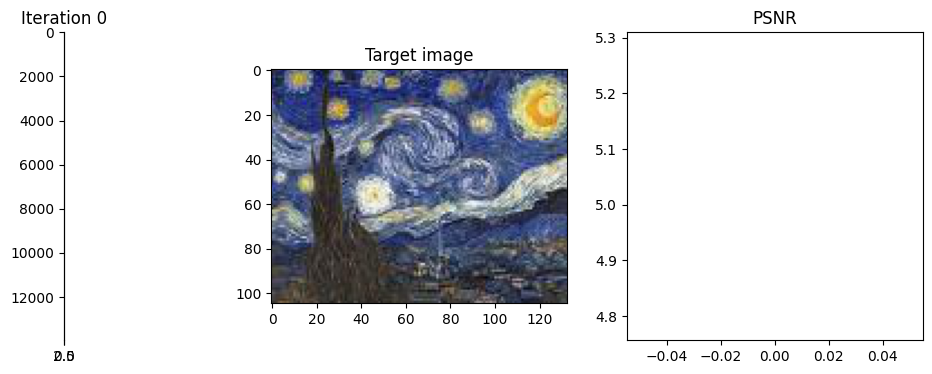

Iteration 2000  Loss: 0.0184  PSNR: 16.48 Time: 0.03 secs per iter 66.68 secs in total


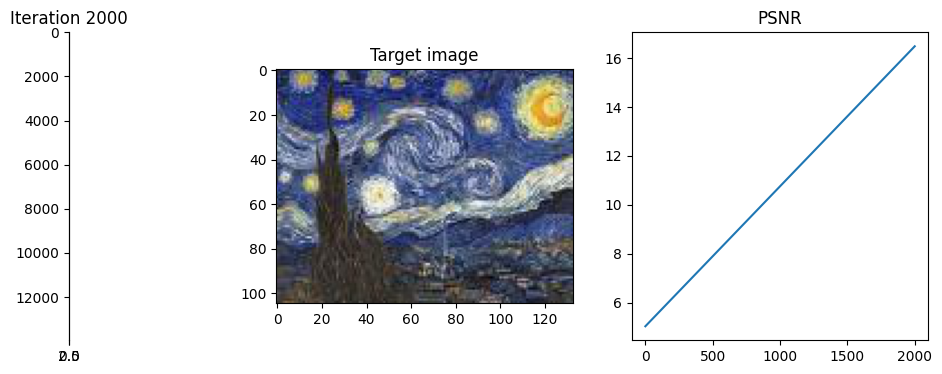

Iteration 4000  Loss: 0.0163  PSNR: 16.86 Time: 0.03 secs per iter 127.31 secs in total


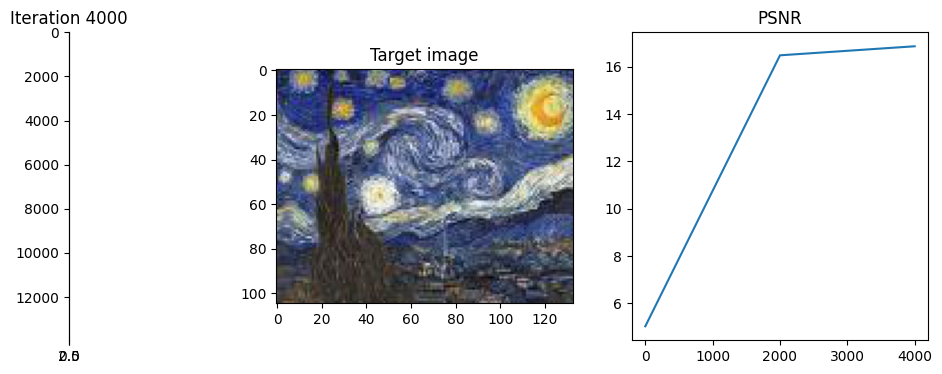

Iteration 6000  Loss: 0.0149  PSNR: 17.31 Time: 0.03 secs per iter 190.29 secs in total


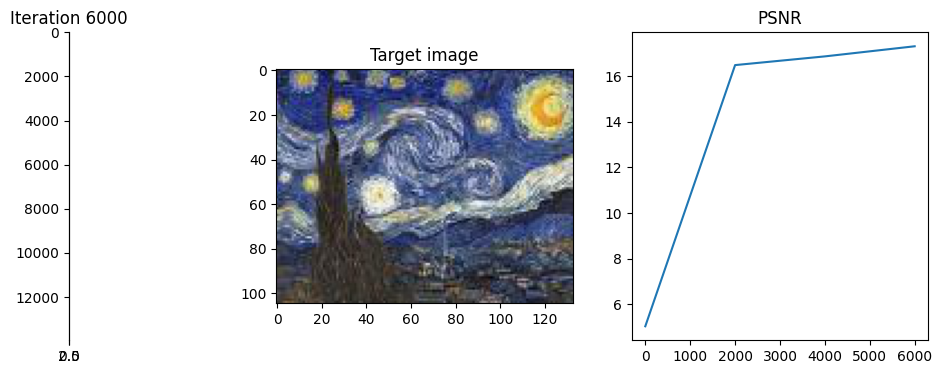

Iteration 8000  Loss: 0.0141  PSNR: 17.35 Time: 0.03 secs per iter 251.74 secs in total


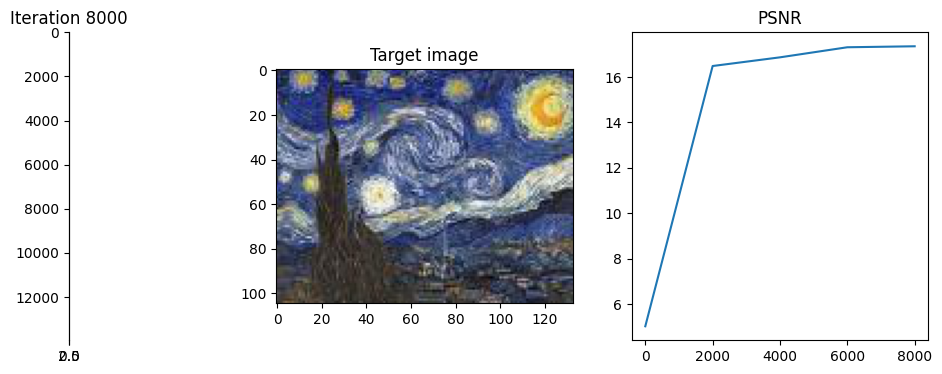

Iteration 10000  Loss: 0.0135  PSNR: 17.74 Time: 0.03 secs per iter 315.02 secs in total


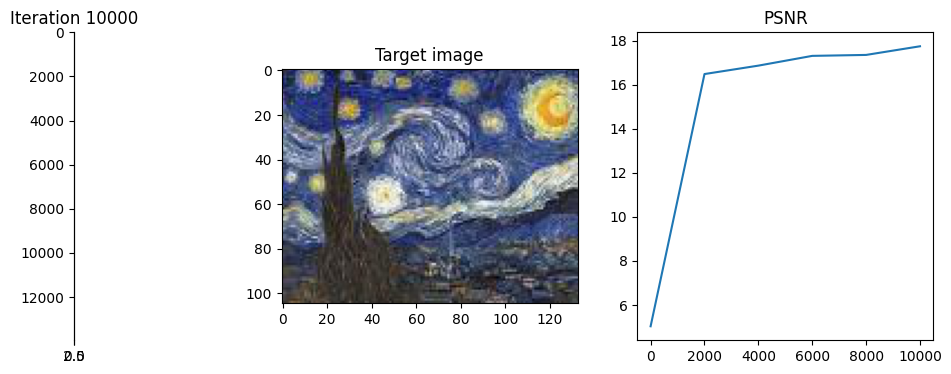

Done!


In [14]:
train_2d_model(model=model_2d, num_frequencies=6)

Iteration 0  Loss: 0.2104  PSNR: 6.77 Time: 0.00 secs per iter 0.16 secs in total


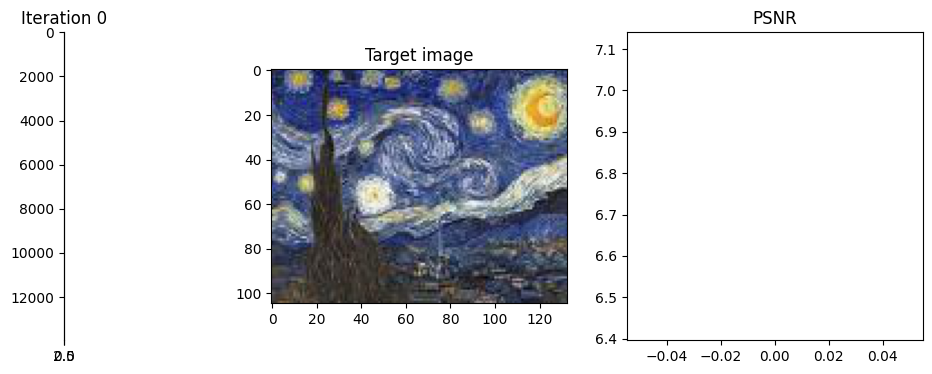

Iteration 2000  Loss: 0.0179  PSNR: 16.89 Time: 0.03 secs per iter 54.85 secs in total


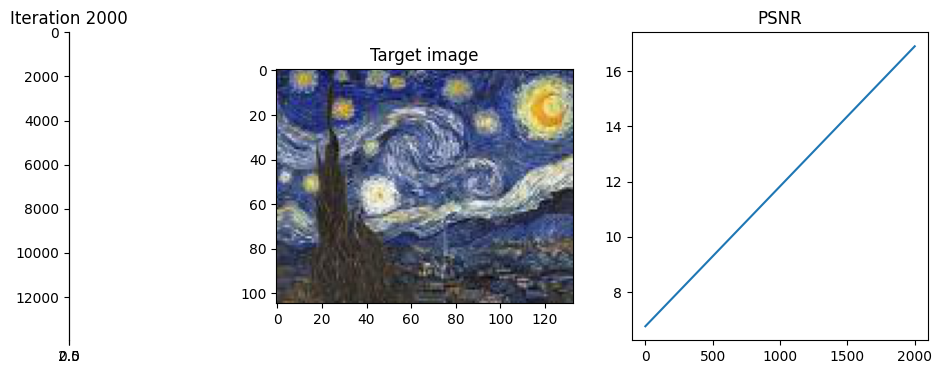

Iteration 4000  Loss: 0.0161  PSNR: 17.62 Time: 0.03 secs per iter 109.69 secs in total


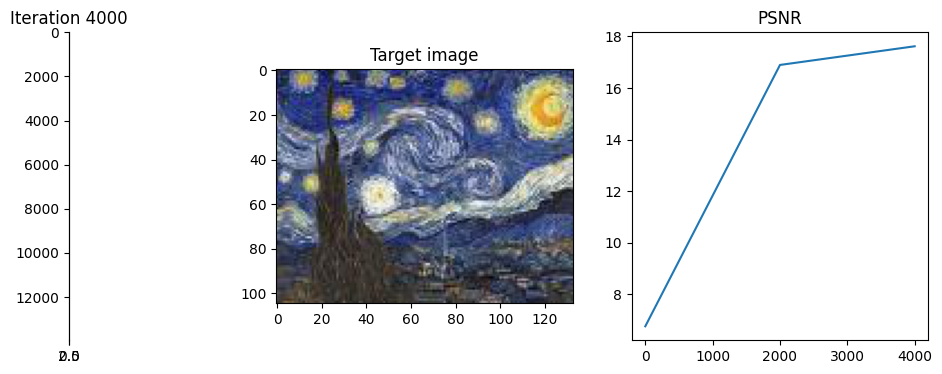

Iteration 6000  Loss: 0.0141  PSNR: 17.14 Time: 0.03 secs per iter 164.68 secs in total


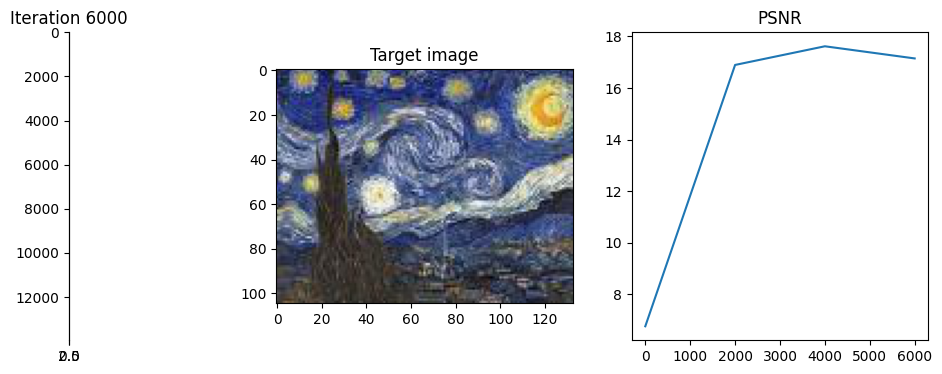

Iteration 8000  Loss: 0.0135  PSNR: 17.30 Time: 0.03 secs per iter 218.10 secs in total


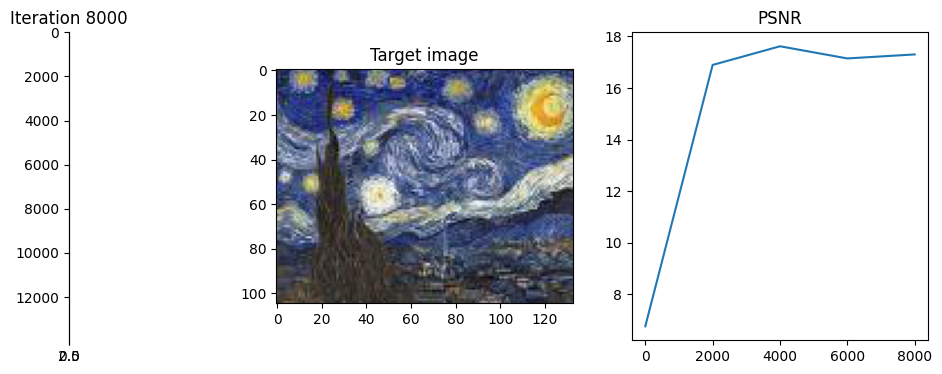

Iteration 10000  Loss: 0.0131  PSNR: 17.97 Time: 0.03 secs per iter 271.61 secs in total


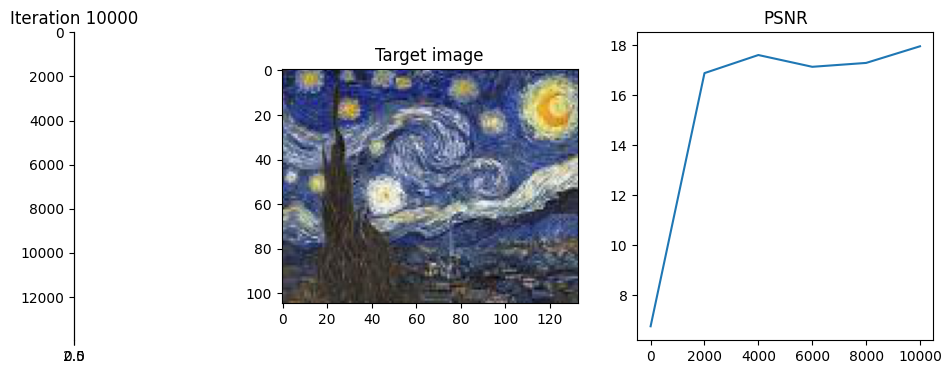

Done!


In [15]:
train_2d_model(model=model_2d, num_frequencies=2)

## Without applied positional encoding


Iteration 0  Loss: 0.2078  PSNR: 6.82 Time: 0.00 secs per iter 0.03 secs in total


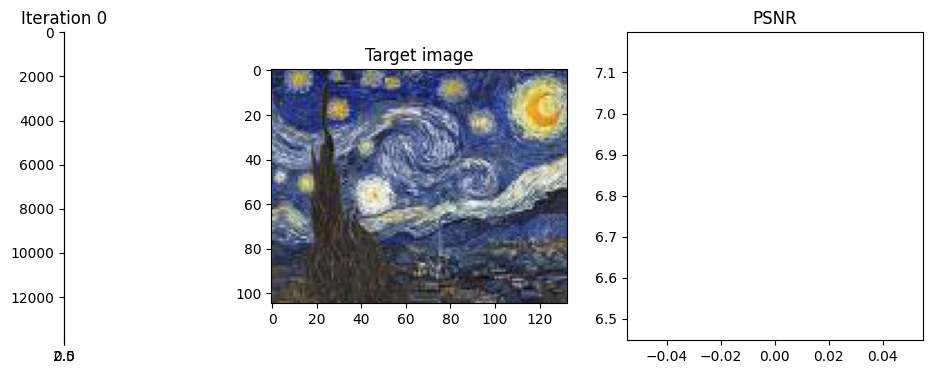

Iteration 2000  Loss: 0.0202  PSNR: 15.26 Time: 0.03 secs per iter 52.64 secs in total


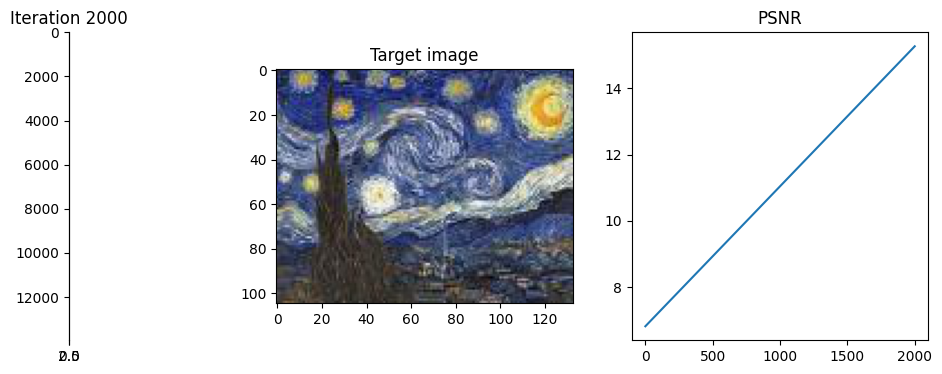

Iteration 4000  Loss: 0.0177  PSNR: 16.87 Time: 0.03 secs per iter 104.50 secs in total


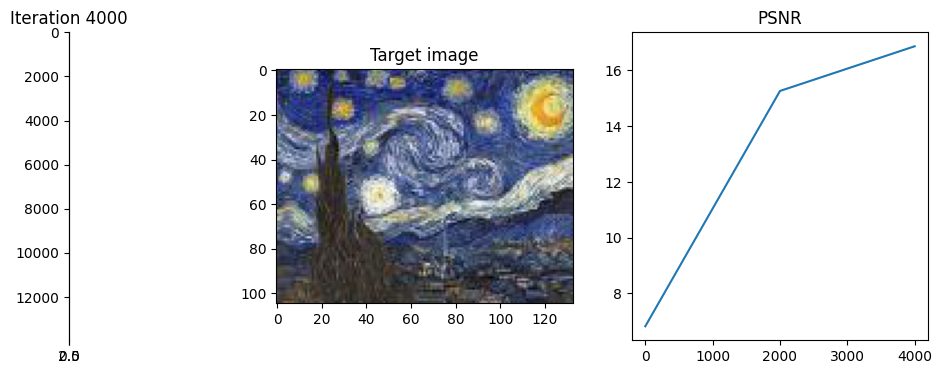

Iteration 6000  Loss: 0.0163  PSNR: 16.77 Time: 0.03 secs per iter 157.69 secs in total


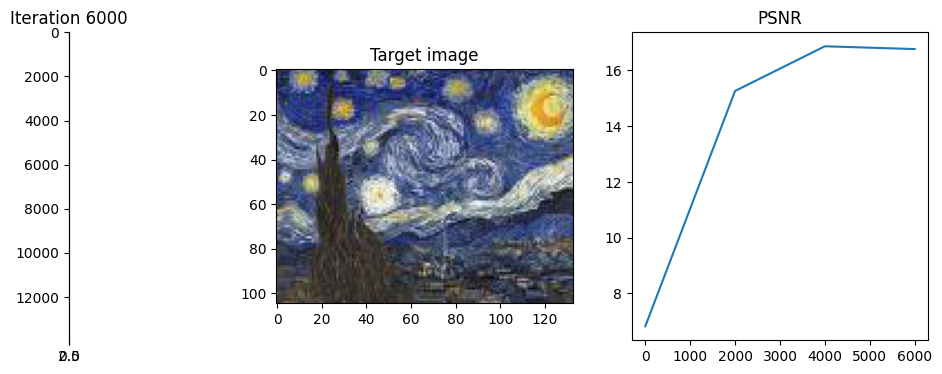

Iteration 8000  Loss: 0.0151  PSNR: 17.20 Time: 0.03 secs per iter 209.76 secs in total


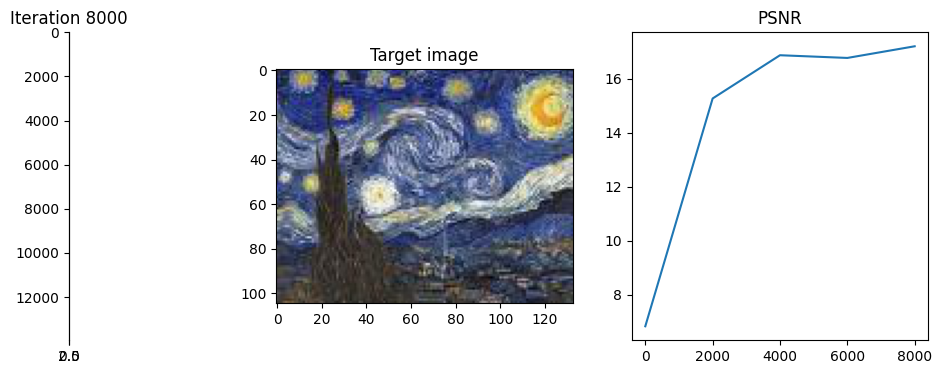

Iteration 10000  Loss: 0.0144  PSNR: 17.47 Time: 0.03 secs per iter 260.64 secs in total


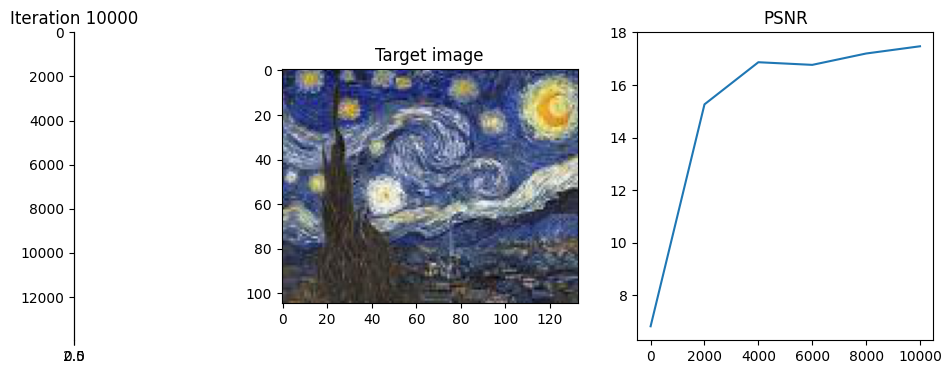

Done!


In [18]:
class model_2d(nn.Module):
    
    """
    Define a 2D model comprising of three fully connected layers,
    two relu activations and one sigmoid activation.
    """
    
    def __init__(self, filter_size=128, num_frequencies=6):
        super().__init__()
        #############################  TODO 1(b) BEGIN  ############################
        self.fun1 = nn.Linear(2,filter_size)
        self.relu = nn.ReLU()
        self.fun2 = nn.Linear(filter_size, filter_size)
        self.fun3 = nn.Linear(filter_size, 3)
        self.sig = nn.Sigmoid()
        #############################  TODO 1(b) END  ##############################        

    def forward(self, x):
        #############################  TODO 1(b) BEGIN  ############################
        x = self.fun1(x)
        x = self.relu(x)
        x = self.fun2(x)
        x = self.relu(x)
        x = self.fun3(x)
        x = self.sig(x)

        #############################  TODO 1(b) END  ##############################  
        return x  
def train_2d_model(model=model_2d(), num_frequencies=6, height=height_painting, width=width_painting, testimg=painting):

    # Optimizer parameters
    lr = 5e-4
    iterations = 10000

    # Number of iters after which stats are displayed
    display = 2000  
    
    # Define the model and initialize its weights.
    model2d = model_2d(num_frequencies=num_frequencies)
    #model2d.to(device)

    def weights_init(m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)

    model2d.apply(weights_init)

    #############################  TODO 1(c) BEGIN  ############################
    # Define the optimizer
    optimizer = torch.optim.Adam(model2d.parameters(), lr=lr)
    #############################  TODO 1(c) END  ############################

    # Seed RNG, for repeatability
    seed = 5670
    torch.manual_seed(seed)
    np.random.seed(seed)

    # Lists to log metrics etc.
    psnrs = []
    iternums = []

    t = time.time()
    t0 = time.time()

    #############################  TODO 1(c) BEGIN  ############################
    # Create the 2D coordinates and apply positional encoding to them
    coords = []
    for i in range(0,height):
      for j in range(0,width):
        coords.append((j, i))
    coords = torch.Tensor(coords)
    #pos = positional_encoding(coords)
    img = testimg.reshape(height*width, 3)
    #############################  TODO 1(c) END  ############################

    for i in range(iterations+1):
        optimizer.zero_grad()
        #############################  TODO 1(c) BEGIN  ############################
        # Run one iteration
        #pos = pos.to(device)
        #img = img.to(device)
        outputs = model2d(coords)

        # Compute mean-squared error between the predicted and target images. Backprop!
        loss = torch.nn.functional.mse_loss(img, outputs)
        loss.backward()
        optimizer.step()

        #############################  TODO 1(c) END  ############################

        # Display images/plots/stats
        if i % display == 0:
            #############################  TODO 1(c) BEGIN  ############################
            # Calculate psnr
            R = torch.max(outputs)
            pred = outputs
            psnr = torch.log10((R**2/loss)**10)
            #############################  TODO 1(c) END  ############################

            print("Iteration %d " % i, "Loss: %.4f " % loss.item(), "PSNR: %.2f" % psnr.item(), \
                "Time: %.2f secs per iter" % ((time.time() - t) / display), "%.2f secs in total" % (time.time() - t0))
            t = time.time()

            psnrs.append(psnr.item())
            iternums.append(i)

            plt.figure(figsize=(13, 4))
            plt.subplot(131)
            plt.imshow(pred.detach().cpu().numpy())
            plt.title(f"Iteration {i}")
            plt.subplot(132)
            plt.imshow(testimg.cpu().numpy())
            plt.title("Target image")
            plt.subplot(133)
            plt.plot(iternums, psnrs)
            plt.title("PSNR")
            plt.show()

    print('Done!')
train_2d_model(model=model_2d, num_frequencies=6)